In [1]:
#Import the necessary packages
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#Read the dataset and reshape so the rows represent viewers and columns represent movies
movie_lens = pd.read_csv('/movielens/ratings.csv')
movie_lens = movie_lens.pivot(index="userId", columns="movieId", values="rating")

In [3]:
class CoordinateAscentMAPEstimate:
    """
    A class to perform Coordinate Ascent MAP (Maximum a Posteriori) Estimation 
    using a Gaussian model for matrix factorization.

    Attributes:
        dataframe (pd.DataFrame): The input data containing user, item, and ratings information.
        K (int): The number of latent factors in the matrix factorization model.
        lambda_theta (float): Regularization parameter for user preferences (theta).
        lambda_beta (float): Regularization parameter for item attributes (beta).
        gamma (float): Learning rate for the optimization process.
    """
    
    def __init__(self, dataframe, K=2, lambda_theta=1, lambda_beta=1, sigma=1, test_size=0.2, random_state=42):
        """
        Initialize the Coordinate Ascent MAPEstimate object.

        Args:
            dataframe (pd.DataFrame): The input data containing user, item, and ratings information.
            K (int, optional): Number of latent factors in the matrix factorization model. Defaults to 2.
            lambda_theta (float, optional): Regularization parameter for user preferences (theta). Defaults to 1.
            lambda_beta (float, optional): Regularization parameter for item attributes (beta). Defaults to 1.
            sigma (float, optional): The standard deviation of the Gaussian distribution. Defaults to 1.
            test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
            random_state (int, optional): The seed used by the random number generator. Defaults to 42.
        """
        self.dataframe = dataframe
        self.K = K
        self.lambda_theta = lambda_theta
        self.lambda_beta = lambda_beta
        self.sigma = sigma
        self.test_size = test_size
        self.random_state = random_state
        self.thetas = None
        self.betas = None
    
    def _init_factors(self, K):
        """
        Initialize the latent factors for users (theta) and items (beta) using a Gaussian distribution.

        This method sets up the initial state for the matrix factorization by creating two matrices: 
        `thetas` for user preferences and `betas` for item attributes. It randomly initializes these 
        matrices based on a Gaussian distribution. Additionally, it splits the input data into training 
        and test sets based on the `test_size` attribute.

        The method also ensures that the original user and item IDs are maintained for reference.

        Args:
            K (int): The number of latent factors to be used in the matrix factorization model.

        Note:
            - The method uses `self.lambda_theta` and `self.lambda_beta` as the standard deviations for
            the Gaussian distributions used to initialize `thetas` and `betas`, respectively.
            - The training and test data sets are created by randomly selecting a subset of the 
            original data (based on `self.test_size`), ensuring the test data is represented as `NaN` 
            in the training set and vice versa.
        """
        X_train = self.dataframe.to_numpy()
        flattened = X_train.flatten()
        num_elements_to_select = int(len(flattened) * self.test_size)

        selected_indices = np.random.choice(len(flattened), num_elements_to_select, replace=False)

        X_test = np.full_like(X_train, np.nan, dtype=float)

        for idx in selected_indices:
            X_test[np.unravel_index(idx, X_train.shape)] = flattened[idx]

        self.X_train = X_train
        self.X_test = X_test
    
        self.thetas = np.random.normal(loc=0, scale=self.lambda_theta, size=(self.X_train.shape[0], K))
        self.betas = np.random.normal(loc=0, scale=self.lambda_beta, size=(self.X_train.shape[1], K))

    def _regularization_term(self, lamb, latent_factor):
        """
        Calculate the regularization term for a given latent factor.

        The regularization term is calculated as a negative inverse square of the lambda parameter
        multiplied by the latent factor. This term is typically used to prevent overfitting by penalizing
        larger values in the latent factor matrices.

        Args:
            lamb (float): The regularization parameter (lambda_theta or lambda_beta).
            latent_factor (np.ndarray): The latent factor matrix (either thetas or betas).

        Returns:
            np.ndarray: The calculated regularization term for the given latent factor.
        """
        return -1 / (lamb ** 2) * latent_factor

    def _product_theta_beta(self):
        """
        Compute the dot product of the theta and beta matrices.

        This method calculates the dot product of the user preferences (thetas) and item attributes (betas)
        matrices. The result is used to approximate the user-item interaction matrix.

        Returns:
            np.ndarray: The dot product of the thetas and betas matrices.
        """
        return np.dot(self.thetas, self.betas.T)
    
    def _rating_diff(self):
        """
        Calculate the difference between actual and predicted ratings.

        This method computes the difference between the observed ratings in the training set (`X_train`)
        and the ratings predicted by the dot product of the theta and beta matrices. Entries in `X_train`
        that are NaN (indicating missing data) are ignored in the calculation.

        Returns:
            np.ndarray: The matrix representing the difference between actual and predicted ratings.
        """
        mask = ~ np.isnan(self.X_train)
        rating_diff = np.where(mask, self.X_train - self._product_theta_beta(),0)
        return rating_diff

    def _get_shapes_of_matrices(self):
        """
        Print the shapes of various matrices used in the Coordinate Ascent MAP Estimation process.

        This method displays the shapes of the data matrix (X_train), thetas, betas, and various other
        matrices derived from them, such as the regularization terms and gradients. It's useful for
        debugging and ensuring that matrix dimensions are compatible for operations.
        """
        print(f'Shape of the data: {self.X_train.shape}')
        print(f'Shape of thetas: {self.thetas.shape}')
        print(f'Shape of betas: {self.betas.shape}')
        print(f'Shape of regularization of theta: {self._regularization_term(self.lambda_theta, self.thetas).shape}')
        print(f'Shape of regularization of beta: {self._regularization_term (self.lambda_beta, self.betas).shape}')
        print(f'Shape of theta dot beta: {self._product_theta_beta().shape}')
        print(f'Shape of rating difference: {self._rating_diff().shape}')
        print(f'Shape of rating difference interacting with beta: {np.dot(self._rating_diff(), self.betas).shape}')
        print(f'Shape of rating difference interacting with theta: {np.dot(self._rating_diff().T, self.thetas).shape}')
        print(f'Shape of theta gradient: {self._theta_gradient().shape}')
        print(f'Shape of beta gradient: {self._beta_gradient().shape}')
    
    def _theta_gradient(self):
        """
        Calculate the gradient of the loss function with respect to the theta matrix.

        This method computes the gradient used to update the user preference factors (thetas) in the 
        optimization step. The gradient is calculated as the sum of the regularization term and a scaled
        interaction term. The interaction term is the product of the rating difference and the item 
        attribute factors (betas), scaled by the inverse of twice the sigma squared.

        Returns:
            np.ndarray: The gradient of the loss function with respect to the theta matrix.
        """
        regularization_term = self._regularization_term(self.lambda_theta, self.thetas)

        rating_diff = self._rating_diff()
        interaction_term = np.dot(rating_diff, self.betas)

        gradient = regularization_term + 1/(2 * self.sigma ** 2) * interaction_term

        return gradient

    def _beta_gradient(self):
        """
        Calculate the gradient of the loss function with respect to the beta matrix.

        Similar to `_theta_gradient`, this method computes the gradient for updating the item attribute 
        factors (betas). It involves calculating a regularization term and an interaction term. The 
        interaction term is the product of the transposed rating difference and the user preference 
        factors (thetas), scaled by the inverse of twice the sigma squared.

        Returns:
            np.ndarray: The gradient of the loss function with respect to the beta matrix.
        """
        regularization_term = self._regularization_term(self.lambda_beta, self.betas)

        rating_diff = self._rating_diff()
        interaction_term = np.dot(rating_diff.T, self.thetas)

        gradient = regularization_term + 1/(2 * self.sigma ** 2) * interaction_term
        
        return gradient

    def log_likelihood(self, theta, beta):
        """
        Calculate the log-likelihood of the model.

        This method computes the log-likelihood of the given theta and beta matrices under the Gaussian 
        assumption. It includes three parts: the log-likelihood of beta, the log-likelihood of theta, 
        and the log-probability of the observed ratings given theta and beta.

        Args:
            theta (np.ndarray): The user preference factors.
            beta (np.ndarray): The item attribute factors.

        Returns:
            float: The total log-likelihood of the model. It is the sum of the log-likelihoods of beta 
            and theta and the log-probability of the observed ratings.

        Note:
            - The log-likelihoods of beta and theta are computed assuming a Gaussian distribution with 
            standard deviations determined by `self.lambda_beta` and `self.lambda_theta`.
            - The log-probability of the observed ratings (non-NaN entries in the ratings matrix) is 
            computed based on the difference between actual and predicted ratings, scaled by the model's 
            sigma (`self.sigma`).
        """
        
        log_p_beta = -0.5 * np.sum(beta**2) / self.lambda_beta**2 # Log-likelihood of beta terms assuming Gaussian distribution

        log_p_theta = -0.5 * np.sum(theta**2) / self.lambda_theta**2 # Log-likelihood of theta terms assuming Gaussian distribution

        rating_diff = self._rating_diff()
        log_p_x_given_theta_beta = -0.5 * np.sum(rating_diff**2) / self.sigma # Log-probability of observed ratings, only compute for non-NaN entries

        total_log_likelihood = log_p_beta + log_p_theta + log_p_x_given_theta_beta # Total log-likelihood

        return total_log_likelihood # Return total log-likelihood

    def basic_fit(self, K, max_iter=10000, sigma=1, tolerance_rel=1e-4, window_size=2, gamma=1, verbose=True):
        """
        Fit the model using Coordinate Ascent.

        This method iteratively updates the latent factors for users (thetas) and items (betas) using 
        gradient ascent. It checks for convergence based on the specified relative tolerance and window 
        size, optionally logging progress at regular intervals. The method reports on the convergence 
        status upon completion and returns the final values of the thetas and betas.

        Args:
            K (int): The number of latent factors in the matrix factorization model.
            max_iter (int, optional): Maximum number of iterations for the optimization. Defaults to 10000.
            sigma (float, optional): Standard deviation used in the model. Defaults to 1. This parameter 
                                    is used in the log likelihood calculation but not directly in this 
                                    method.
            tolerance_rel (float, optional): Relative tolerance for convergence. Defaults to 1e-4.
            window_size (int, optional): Number of log likelihood values to consider for the convergence 
                                        check. Defaults to 2.
            gamma (float, optional): Learning rate for the optimization process. Defaults to 1.
            verbose (bool, optional): If True, the method prints iteration logs and convergence status. 
                                    Defaults to True.

        Returns:
            tuple: A tuple containing the final values of thetas, betas, and a boolean indicating 
                whether convergence was achieved.
        """
        self._init_factors(K=K)  # Initialize latent factors for users and items.
        converged = False  # Flag to track if the model has converged.
        iteration = 0  # Counter to keep track of the number of iterations.
        self.log_likelihoods = []  # List to store log likelihood values for each iteration.
        pct_changes = []  # List to store percentage changes in log likelihood to monitor convergence.

        while not converged and iteration < max_iter:  # Loop until convergence or max iterations are reached.
            if verbose:
                self._print_iteration_log(iteration)  # Print current iteration number for monitoring, if verbose is True.
            self._update_factors(gamma)  # Update user and item latent factors using gradient ascent.
            log_likelihood = self._calculate_log_likelihood()  # Calculate current log likelihood.
            self.log_likelihoods.append(log_likelihood)  # Append current log likelihood to the list.

            if len(self.log_likelihoods) > window_size:  # Check if enough data points are available for convergence check.
                pct_change = self._check_convergence(window_size, tolerance_rel)  # Check for convergence.
                pct_changes.append(pct_change)  # Append percentage change in log likelihood.
                converged = pct_change <= tolerance_rel  # Update convergence flag based on the tolerance.

                if self._handle_divergence(window_size):  # Check for divergence in the optimization process.
                    break  # Exit loop if divergence is detected.

            iteration += 1  # Increment iteration counter.
        if verbose:
            self._report_convergence_status(converged, iteration, K, gamma)  # Report the convergence status, if verbose is True.
        return self.thetas, self.betas, converged  # Return the final latent factors and convergence status.

    def optimal_fit(self, Ks, gammas):
        """
        Find the optimal combination of K (latent factors) and gamma (learning rate) for the model.

        This method iterates over a range of values for K and gamma, fitting the model for each 
        combination and evaluating its performance based on the log-likelihood calculated on the test 
        set. The best performing combination, indicated by the highest log-likelihood, is identified 
        and returned.

        Args:
            Ks (list of int): A list of different numbers of latent factors to be tried.
            gammas (list of float): A list of different learning rates to be evaluated.

        Returns:
            tuple: A tuple containing the best K, best gamma, the highest log-likelihood achieved, and 
                a dictionary of results mapping each (K, gamma) combination to its corresponding 
                log-likelihood.

        Note:
            - For each (K, gamma) combination, the model is fitted using `basic_fit`.
            - If a particular combination does not converge, it is skipped, and a message is printed.
            - The log-likelihood for the test set is calculated using a Gaussian density function,
            considering only the non-NaN entries in the test data.
        """
        best_log_likelihood = -np.inf  # Initialize the best log likelihood to negative infinity for comparison.
        best_K = None  # Initialize the best value of K (latent factors) as None.
        best_gamma = None  # Initialize the best value of gamma (learning rate) as None.
        results = {}  # Dictionary to store log likelihoods for each (K, gamma) combination.

        var = self.sigma  # Variance of the Gaussian distribution used in the model.
        factor = 1 / np.sqrt(2 * np.pi * var)  # Pre-compute the factor for Gaussian density calculation.

        for K in Ks:  # Iterate over all specified values of K.
            for gamma in gammas:  # Iterate over all specified values of gamma.
                print(f'Fitting the model at K = {K} and gamma = {gamma}.')  # Print the current combination of K and gamma.
                # Fit the model with the current K and gamma, and get the expected thetas and betas and convergence status.
                expected_theta, expected_beta, has_converged = self.basic_fit(K=K, gamma=gamma)
                mask = ~np.isnan(self.X_test)  # Create a mask for non-NaN values in the test dataset.

                if not has_converged:  # Check if the model fitting converged.
                    print(f"K = {K}, Gamma = {gamma} did not converge.")  # Print a message if the model did not converge.
                    continue  # Skip the current iteration and move to the next combination.

                mu = np.dot(expected_theta, expected_beta.T)  # Compute the predicted ratings.
                # Calculate the Gaussian density for each predicted rating.
                density = factor * np.exp(-0.5 * ((self.X_test - mu) ** 2) / var)
                masked_density = np.where(mask, density, 0)  # Apply mask to ignore NaNs in the test set.
                predicted_log_likelihood = np.sum(masked_density)  # Sum up the log likelihood for the test set.

                results[(K, gamma)] = predicted_log_likelihood  # Store the log likelihood for the current combination.

                if predicted_log_likelihood > best_log_likelihood:  # Check if the current log likelihood is the best so far.
                    best_log_likelihood = predicted_log_likelihood  # Update the best log likelihood.
                    best_K = K  # Update the best K.
                    best_gamma = gamma  # Update the best gamma.

        return best_K, best_gamma, best_log_likelihood, results  # Return the best parameters and all results.

    def _print_iteration_log(self, iteration):
        """
        Print the current iteration number for monitoring progress.

        This method outputs the iteration number at regular intervals (every 1000 iterations) 
        to the console for tracking the progress of the model fitting process.

        Args:
            iteration (int): The current iteration number in the model fitting process.
        """
        if iteration % 1000 == 0:
            print(f'Iteration: {iteration}')

    def _update_factors(self, gamma):
        """
        Update latent factors using gradient ascent.

        This method modifies the user preference factors (thetas) and item attribute factors 
        (betas) in place. It uses gradient ascent to optimize these factors, adjusting them by 
        a step proportional to the respective gradients and the learning rate (gamma).

        Args:
            gamma (float): The learning rate used to scale the gradient ascent step.
        """
        self.thetas += gamma * self._theta_gradient()
        self.betas += gamma * self._beta_gradient()

    def _calculate_log_likelihood(self):
        """
        Calculate the log likelihood for the current state of the model.

        This method computes the log likelihood of the model given the current values of the 
        user preferences (thetas) and item attributes (betas). The log likelihood is a measure 
        of how well the model explains the observed data.

        Returns:
            float: The calculated log likelihood value for the current model state.
        """
        return self.log_likelihood(self.thetas, self.betas)

    def _check_convergence(self, window_size, tolerance_rel):
        """
        Check if the model has converged.

        Convergence is determined by examining the average percentage change in the log likelihood 
        over a specified number of recent iterations (window). If the change is below the given 
        relative tolerance, the model is considered to have converged.

        Args:
            window_size (int): The number of most recent log likelihood values to consider for checking convergence.
            tolerance_rel (float): The relative tolerance threshold for convergence.

        Returns:
            float: The average percentage change in log likelihood over the specified window.
        """
        windowed_ll = np.array(self.log_likelihoods[-window_size:])
        diffs = np.diff(windowed_ll)

        diffs = np.nan_to_num(diffs, nan=np.inf, posinf=np.inf, neginf=-np.inf)
        windowed_ll = np.nan_to_num(windowed_ll, nan=np.inf, posinf=np.inf, neginf=-np.inf)

        pct_change = np.abs(diffs / windowed_ll[:-1])
        return np.mean(pct_change)

    def _handle_divergence(self, window_size):
        """
        Check and handle potential divergence in the model optimization.

        Divergence is checked by looking for infinities or NaN values in the recent log likelihood values.
        A decreasing trend in the log likelihood is also an indication of divergence. If divergence is detected,
        the method prints a warning message.

        Args:
            window_size (int): The number of most recent log likelihood values to consider for detecting divergence.

        Returns:
            bool: True if divergence is detected, otherwise False.
        """
        windowed_ll = np.array(self.log_likelihoods[-window_size:])
        if np.isinf(windowed_ll).any() or np.isnan(windowed_ll).any():
            print("Warning: Log-likelihood contains inf or nan, check the model computations.")
            return True
        elif windowed_ll[-1] < windowed_ll[0]:
            print("Warning: Log-likelihood is decreasing, check the learning rate or model assumptions.")
            return True
        return False

    def _report_convergence_status(self, converged, iteration, K, gamma):
        """
        Report the convergence status of the model.

        Prints a message indicating whether the model has successfully converged based on the
        specified criteria. If convergence is achieved, the method prints the iteration number 
        and the parameters K and gamma at which convergence occurred.

        Args:
            converged (bool): Whether the model has converged.
            iteration (int): The iteration number where the process ended or stopped.
            K (int): Number of latent factors used in the model.
            gamma (float): Learning rate used in the model.
        """
        if converged:
            print(f'Convergence occurred at iteration {iteration} for K = {K} and gamma = {gamma}.')
        else:
            print("Model needs refining as convergence did not occur.")

In [ ]:
K = [10, 50, 100]  # Define a list of different numbers of latent factors (K) to be evaluated.
gammas = [0.0001, 0.001, 0.01, 0.1]  # Define a list of different learning rates (gamma) to be tested.

# Initialize the Coordinate Ascent MAP Estimate model with the movie_lens dataframe and regularization parameters.
model = CoordinateAscentMAPEstimate(dataframe=movie_lens, lambda_theta=1, lambda_beta=1)

# Call the optimal_fit method of the model to find the best combination of K and gamma.
# This method will return the best K (number of latent factors), the best gamma (learning rate),
# the highest log likelihood achieved, and a dictionary containing the log likelihoods for each combination of K and gamma.
best_K, best_gamma, best_log_likelihood, results = model.optimal_fit(Ks=K, gammas=gammas)

K: 10, Gammas_plot: [0.0001, 0.001, 0.01, 0.1], Likelihoods: [6511.133522790732, 7134.239942409477, nan, nan]
K: 50, Gammas_plot: [0.0001, 0.001, 0.01, 0.1], Likelihoods: [nan, 7887.749613737926, nan, nan]
K: 100, Gammas_plot: [0.0001, 0.001, 0.01, 0.1], Likelihoods: [nan, 8006.793726359581, nan, nan]


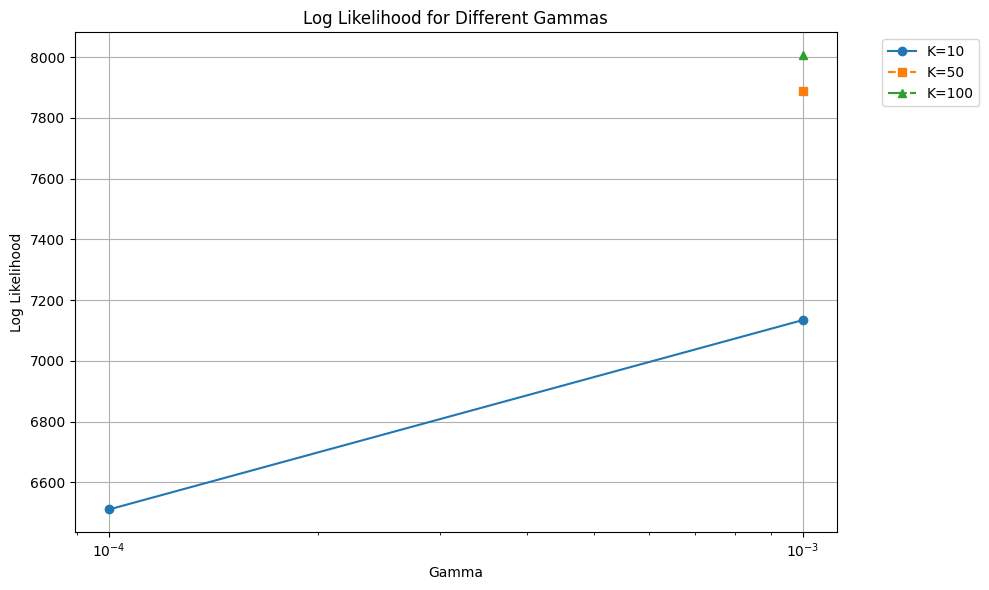

In [ ]:
plt.figure(figsize=(10, 6))  # Create a new figure for plotting with a size of 10x6 inches.

markers = ['o', 's', '^', 'D']  # Define different marker styles for the plot lines.
line_styles = ['-', '--', '-.', ':']  # Define different line styles for the plot lines.

# Loop through each value of K (number of latent factors) for plotting.
for i, k in enumerate(K):
    gammas_plot = []  # List to store gamma values for plotting.
    likelihoods = []  # List to store corresponding log likelihoods.

    # Loop through each gamma value.
    for gamma in gammas:
        if (k, gamma) in results:
            gammas_plot.append(gamma)  # Append the gamma value.
            likelihoods.append(results[(k, gamma)])  # Append the corresponding log likelihood.
        else:
            gammas_plot.append(gamma)  # Append the gamma value.
            likelihoods.append(np.nan)  # Append NaN if the result is missing.

    # Print the current values of K, gammas, and likelihoods for debugging purposes.
    print(f"K: {k}, Gammas_plot: {gammas_plot}, Likelihoods: {likelihoods}")

    # Plot the results for the current value of K.
    # Use the modulus operator to cycle through markers and line styles.
    plt.plot(gammas_plot, likelihoods, label=f'K={k}', marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)])

# Set the labels and title for the plot.
plt.xlabel('Gamma')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood for Different Gammas')

plt.xscale('log')  # Use logarithmic scale for x-axis to handle wide range of gamma values.

# Set the legend outside the plot area for better visibility.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)  # Enable grid for easier reading of values.
plt.tight_layout()  # Adjust the layout to fit all elements neatly.
plt.show()  # Display the plot.

Gamma: 0.0001, Ks_plot: [10], Likelihoods: [6511.133522790732]
Gamma: 0.001, Ks_plot: [10, 50, 100], Likelihoods: [7134.239942409477, 7887.749613737926, 8006.793726359581]
Gamma: 0.01, Ks_plot: [], Likelihoods: []
Gamma: 0.1, Ks_plot: [], Likelihoods: []


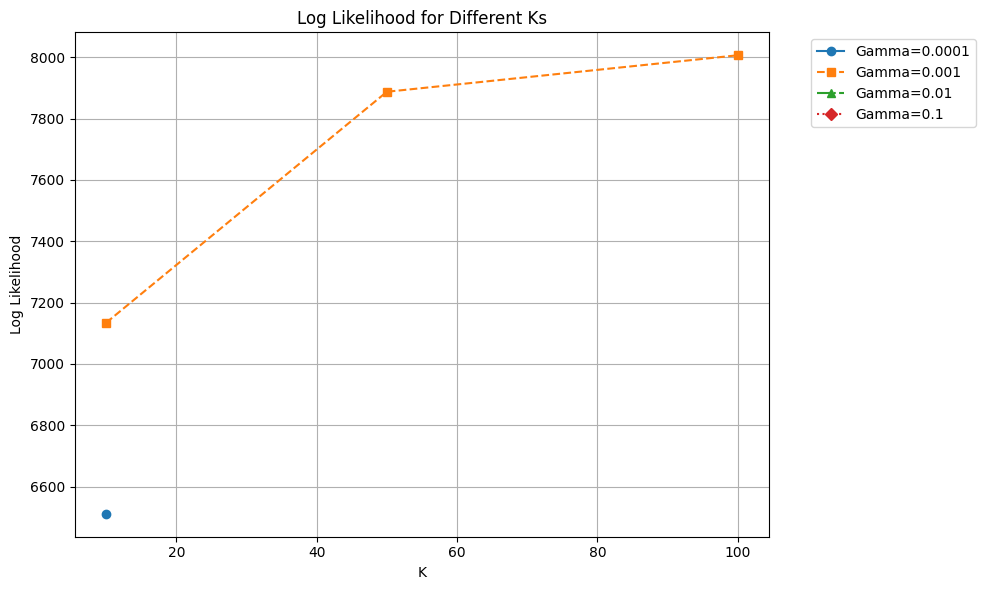

In [ ]:
# Setup for the plot.
plt.figure(figsize=(10, 6))  # Create a new figure with specified size (10 inches wide, 6 inches tall).

markers = ['o', 's', '^', 'D']  # Define marker styles for different gamma values.
line_styles = ['-', '--', '-.', ':']  # Define line styles for different gamma values.

# Iterate over each gamma value to plot the corresponding log likelihoods for different K values.
for i, gamma in enumerate(gammas):
    Ks_plot = []  # List to store the K values for plotting.
    likelihoods = []  # List to store the corresponding log likelihoods.

    # Iterate over each K value.
    for k in K:
        # Check if the result for this combination of K and gamma exists.
        if (k, gamma) in results:
            Ks_plot.append(k)  # Append the K value.
            likelihoods.append(results[(k, gamma)])  # Append the corresponding log likelihood.
    
    # Print the current gamma, K values, and likelihoods for debugging purposes.
    print(f"Gamma: {gamma}, Ks_plot: {Ks_plot}, Likelihoods: {likelihoods}")

    # Plot the results for the current gamma value.
    plt.plot(Ks_plot, likelihoods, label=f'Gamma={gamma}', marker=markers[i], linestyle=line_styles[i])

# Setting labels and title for the plot.
plt.xlabel('K')  # Label for the x-axis.
plt.ylabel('Log Likelihood')  # Label for the y-axis.
plt.title('Log Likelihood for Different Ks')  # Title of the plot.

# Positioning the legend outside of the plot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)  # Enable grid for better readability.
plt.tight_layout()  # Adjust layout to fit all elements.
plt.show()  # Display the plot.


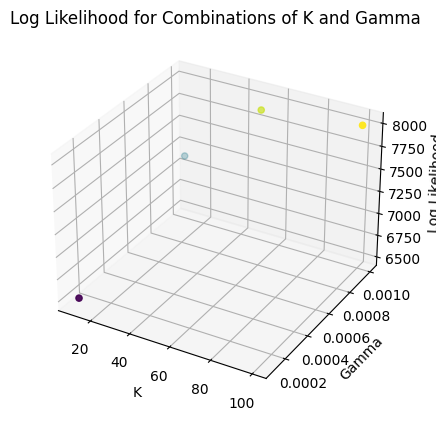

In [ ]:
fig = plt.figure()  # Create a new figure.
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot to the figure.

# Lists to store the data points for K, gamma, and their corresponding log likelihoods.
Ks_plot = []  # List for storing values of K.
gammas_plot = []  # List for storing values of gamma.
likelihoods = []  # List for storing log likelihoods.

# Iterate over each combination of K and gamma.
for K in K:
    for gamma in gammas:
        # Check if the result for this combination of K and gamma exists in the 'results' dictionary.
        if (K, gamma) in results:
            Ks_plot.append(K)  # Append the value of K.
            gammas_plot.append(gamma)  # Append the value of gamma.
            likelihoods.append(results[(K, gamma)])  # Append the corresponding log likelihood.

# Plotting the data.
# The scatter plot uses Ks_plot, gammas_plot, and likelihoods as coordinates in 3D space.
# The color mapping 'viridis' is used to visually differentiate data points based on their log likelihood values.
ax.scatter(Ks_plot, gammas_plot, likelihoods, c=likelihoods, cmap='viridis')

# Setting labels for each axis.
ax.set_xlabel('K')  # Label for the K axis (number of latent factors).
ax.set_ylabel('Gamma')  # Label for the gamma axis (learning rate).
ax.set_zlabel('Log Likelihood')  # Label for the log likelihood axis.

plt.title('Log Likelihood for Combinations of K and Gamma')  # Title of the plot.
plt.show()  # Display the plot.

Optimal value is K=100 and gamma = 0.001


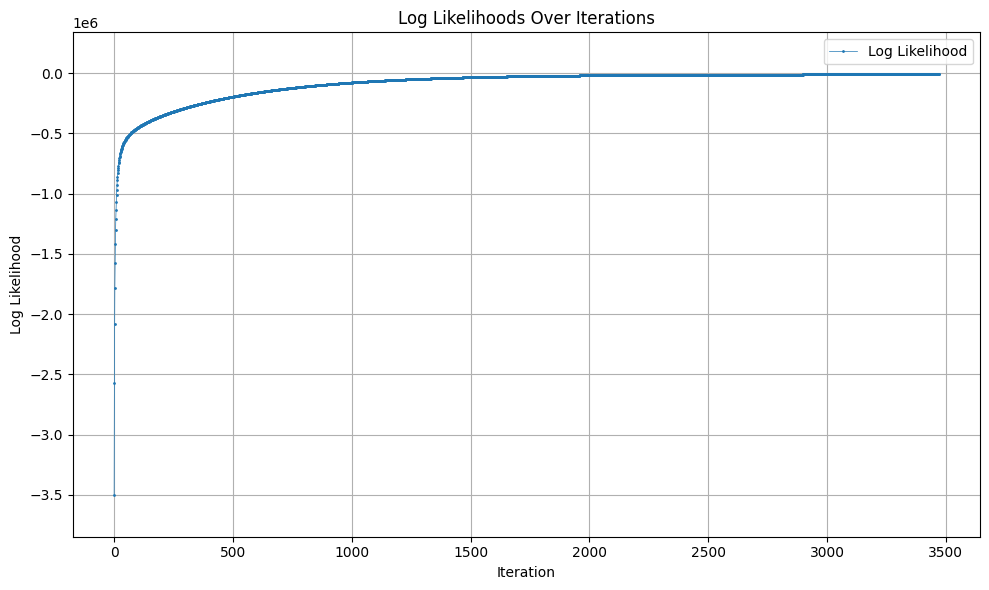

In [5]:
model = CoordinateAscentMAPEstimate(movie_lens)  # Initialize the model with the movie_lens dataset.
model.basic_fit(K=100, gamma=0.001, verbose=False)  # Fit the model with 100 latent factors (K) and a learning rate (gamma) of 0.001.

plt.figure(figsize=(10, 6))  # Set the figure size for the plot (10 inches wide, 6 inches tall).

# Plot the log likelihoods.
# The plot uses a thin line (linewidth=0.5) with small markers (markersize=1) for clarity.
plt.plot(model.log_likelihoods, label='Log Likelihood', marker='o', linestyle='-', linewidth=0.5, markersize=1)

# Add title and axis labels.
plt.title("Log Likelihoods Over Iterations")  # Title of the plot.
plt.xlabel("Iteration")  # Label for the x-axis.
plt.ylabel("Log Likelihood")  # Label for the y-axis.

plt.grid(True)  # Enable grid for better readability of the plot.

# Determine the maximum and minimum log likelihood values for adjusting the y-axis scale.
max_log_likelihood = max(model.log_likelihoods)
min_log_likelihood = min(model.log_likelihoods)

# Set the y-axis limits to provide a better view of the log likelihood variations.
# This approach adds a 10% buffer above and below the actual min and max values for clarity.
plt.ylim([min_log_likelihood - (max_log_likelihood - min_log_likelihood) * 0.1, 
          max_log_likelihood + (max_log_likelihood - min_log_likelihood) * 0.1])

plt.legend()  # Add a legend to the plot.

plt.tight_layout()  # Apply tight layout settings for a neat presentation of the plot.

plt.show()  # Display the plot.